<a href="https://githubtocolab.com/snel-repo/lfads-tutorial/blob/main/lfads_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LFADS in the Neural Latents Benchmark
Latent Factor Analysis via Dynamical Systems (LFADS) is a method for learning low-dimensional representations of neural data by modeling that data as a dynamical system. You can read more about LFADS in [Pandarinath et al 2018, *Nat Methods*](https://www.nature.com/articles/s41592-018-0109-9) and [Sussillo et al 2016, *arXiv*](https://arxiv.org/abs/1608.06315). The **goal** of this notebook is to provide an overview of how to use the [`autolfads-tf2`](https://github.com/snel-repo/autolfads-tf2) code package to run LFADS on the data provided in the [Neural Latents Benchmark](https://neurallatents.github.io/).

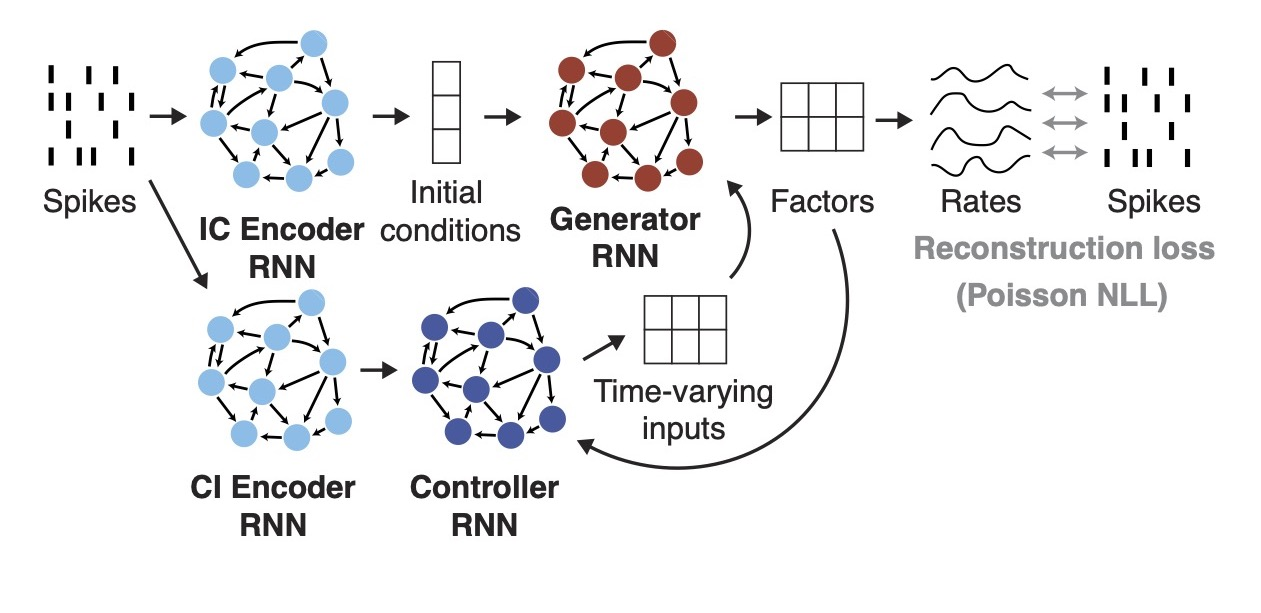

## Setup
First, we'll install `lfads_tf2` from the [`autolfads-tf2` repository](https://github.com/snel-repo/autolfads-tf2). To load data and make submissions for the Neural Latents Benchmark, we'll also install [`dandi`](https://pypi.org/project/dandi/) and [`nlb_tools`](https://github.com/neurallatents/nlb_tools).

NOTE: For your installed packages to load, you will need to restart your Colab notebook after this step.

In [1]:
# If we're in Google Colab, install dependencies
import sys

setup_cmd = """
git clone -b nlb https://github.com/snel-repo/autolfads-tf2.git
pip install -e ./autolfads-tf2/lfads-tf2
pip install git+https://github.com/neurallatents/nlb_tools.git
pip install dandi
git clone https://github.com/snel-repo/lfads-tutorial.git
"""

with open('setup.sh', 'w') as f:
    if 'google.colab' in sys.modules:
        print(setup_cmd, file=f)

!bash setup.sh

In [2]:
# ignore future warnings to minimize console output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Workaround for installing new packages in Google Colab
# Check that the packages can be loaded. If not, restart the runtime.
import os

try:
    import lfads_tf2
    import nlb_tools
except ModuleNotFoundError:
    print('lfads_tf2 and/or nlb_tools not found.'
          'Make sure that you have installed them. Restarting notebook.')
    os.kill(os.getpid(), 9)

In [4]:
# imports
from nlb_tools.nwb_interface import NWBDataset
from nlb_tools.make_tensors import (make_train_input_tensors,
                                    make_eval_input_tensors,
                                    make_eval_target_tensors,
                                    save_to_h5)
from nlb_tools.evaluation import evaluate

import numpy as np
import h5py

import logging

logging.basicConfig(level=logging.INFO)

## Load data

To facilitate working with the NWB format used with our datasets, `nlb_tools` provides an `NWBDataset` class, which can load from the dataset files and perform simple preprocessing operations. Note that this class is specifically written for the NWB files created for the Neural Latents Benchmark, so it will likely not work with other NWB files.

To load a dataset, you can simply create an `NWBDataset` and provide the path to the dataset files.

In [5]:
# Data locations
data_url_dict = {
    'mc_maze': 'https://dandiarchive.org/dandiset/000128',
    'mc_rtt': 'https://dandiarchive.org/dandiset/000129',
    'area2_bump': 'https://dandiarchive.org/dandiset/000127',
    'dmfc_rsg': 'https://dandiarchive.org/dandiset/000130',
    'mc_maze_large': 'https://dandiarchive.org/dandiset/000138',
    'mc_maze_medium': 'https://dandiarchive.org/dandiset/000139',
    'mc_maze_small': 'https://dandiarchive.org/dandiset/000140',
}
data_dir = './data'
datapath_dict = {
    'mc_maze': f'{data_dir}/000128/sub-Jenkins/',
    'mc_rtt': f'{data_dir}/000129/sub-Indy/',
    'area2_bump': f'{data_dir}/000127/sub-Han/',
    'dmfc_rsg': f'{data_dir}/000130/sub-Haydn/',
    'mc_maze_large': f'{data_dir}/000138/sub-Jenkins/',
    'mc_maze_medium': f'{data_dir}/000139/sub-Jenkins/',
    'mc_maze_small': f'{data_dir}/000140/sub-Jenkins/',
}
prefix_dict = {
    'mc_maze': '*full',
    'mc_maze_large': '*large',
    'mc_maze_medium': '*medium',
    'mc_maze_small': '*small',
}

### Download the data
The datasets for the  Neural Latents Benchmark are all hosted on Dandi. They can be downloaded from the following URLs:   

| Name | URL |
| :--- | :-- |
| Area2_Bump | https://dandiarchive.org/dandiset/000127 |
| DMFC_RSG | https://dandiarchive.org/dandiset/000130 |
| MC_Maze | https://dandiarchive.org/dandiset/000128 |
| MC_Maze_Large | https://dandiarchive.org/dandiset/000138 |
| MC_Maze_Medium | https://dandiarchive.org/dandiset/000139 |
| MC_Maze_Small | https://dandiarchive.org/dandiset/000140 |
| MC_RTT | https://dandiarchive.org/dandiset/000129 |


In [6]:
# Choose the dataset you want to use
dataset_name = 'mc_maze_large'

# Get the URL for the dataset
data_url = data_url_dict[dataset_name]

# Create a directory to save the data
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [7]:
# Download the dataset
!dandi download -o $data_dir -e refresh $data_url

PATH                 SIZE DONE    DONE% CHECKSUM STATUS MESSAGE   
dandiset.yaml                                           updating  
Summary:                  0 Bytes                       1 updating
                          <0.00%                                  dandiset.yaml                                    done   updated   
Summary:                  0 Bytes                1 done 1 updated PATH                          SIZE      DONE    DONE% CHECKSUM STATUS MESSAGE   
dandiset.yaml                                                  done   updated   
...arge_desc-test_ecephys.nwb                                                   
Summary:                      0 Bytes   0 Bytes                1 done 1 updated 
                              +149.4 MB 0.00%                                   ...arge_desc-test_ecephys.nwb 802.4 kB                                          
Summary:                      802.4 kB  0 Bytes                1 done 1 updated 
                              +148

In [8]:
# Load data from NWB file
datapath = datapath_dict[dataset_name]
dataset = NWBDataset(
    datapath,
    skip_fields=['joint_ang', 'joint_vel', 'muscle_len', 'muscle_vel'])


INFO:nlb_tools.nwb_interface:Loading ./data/000138/sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb
INFO:nlb_tools.nwb_interface:Loading ./data/000138/sub-Jenkins/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb


## Modeling pipeline

The module `make_tensors` contains functions that shape data into the format we use and expect for submission and evaluation. In general, the data should be in the form of 3D arrays with the first dimension being trials, second being time, and third being channels/features. Here is a brief summary of the main high-level functions provided:
* `make_train_input_tensors` - Creates arrays containing training data that can be used to fit a model.
* `make_eval_input_tensors` - Creates arrays containing data that can be passed through a model to generate predictions for evaluation or validation.
* `make_eval_target_tensors` - Creates arrays containing true target values for submission evaluation. This function cannot be used for the test split, since the test split evaluation data is not publicly available, but it is what we use to create our evaluation data files.

All three functions can save the output in HDF5 format with `save_file=True` and/or return it as a python dictionary with `return_dict=True` (both are `True` by default). The `.h5` files will have the same structure as the python dictionaries shown here. In addition, these functions all by default use parameters defined in `PARAMS` in `make_tensors.py`, which will create arrays with our desired specifications for each dataset. These parameters can be changed with the `update_params` argument if desired.

### Make the model input
First, we will create arrays for input with `make_train_input_tensors` and `make_eval_input_tensors`. You can choose to run the notebook for the validation phase or the test phase. Results for the test phase cannot be viewed unless you submit to EvalAI.

In [9]:
## Dataset preparation

# Choose the phase here, either 'val' for the Validation phase or 'test' for the Test phase
# Note terminology overlap with 'train', 'val', and 'test' data splits -
# the phase name corresponds to the data split that predictions are evaluated on
phase = 'val'

# Specify the train-val split
valid_ratio = 0.2

# Choose the bin width and resample
bin_size_ms = 5
dataset.resample(bin_size_ms)

# Create suffix for group naming later
suf = '' if (bin_size_ms == 5) else f'_{int(bin_size_ms)}'

INFO:nlb_tools.nwb_interface:Resampling data to 5 ms.


In [10]:
# Specify paths for saving the LFADS input to a file
lfads_in_dir = './lfads_input'
if not os.path.exists(lfads_in_dir):
    os.makedirs(lfads_in_dir)

prefix = prefix_dict.get(dataset_name, '')
savepath_train = f'./lfads_input/{dataset_name}{suf}_train_lfads.h5'
savepath_test = f'./lfads_input/{dataset_name}{suf}_test_lfads.h5'

In [11]:
# Extract train data

# Create input tensors, returned in dict form
train_split = 'train' if (phase == 'val') else ['train', 'val']
data_dict = make_train_input_tensors(dataset, dataset_name, train_split,
                                     save_file=False, include_forward_pred=True)

tlen = data_dict['train_spikes_heldin'].shape[1]
num_heldin = data_dict['train_spikes_heldin'].shape[2]
num_heldout = data_dict['train_spikes_heldout'].shape[2]
fp_steps = data_dict['train_spikes_heldin_forward'].shape[1]
spikes = np.hstack([
    np.dstack([data_dict['train_spikes_heldin'],
               data_dict['train_spikes_heldout']]),
    np.dstack([data_dict['train_spikes_heldin_forward'],
               data_dict['train_spikes_heldout_forward']]),
])

num_trials = len(spikes)
valid_inds = np.arange(0, num_trials, int(1./valid_ratio))
train_inds = np.delete(np.arange(num_trials), valid_inds)

with h5py.File(savepath_train, 'w') as h5file:
    h5file.create_dataset('train_inds', data=train_inds)
    h5file.create_dataset('valid_inds', data=valid_inds)
    h5file.create_dataset('train_data', data=spikes[train_inds])
    h5file.create_dataset('valid_data', data=spikes[valid_inds])

INFO:nlb_tools.nwb_interface:Aligned 375 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Aligned 375 trials to move_onset_time with offset of (450, 650.0) ms and margin of 0.


In [12]:
# Extract test data

# Split for evaluation is same as phase name
eval_split = phase

# Make data tensors
data_dict = make_eval_input_tensors(dataset, dataset_name, eval_split,
                                    save_file=False)
num_trials = len(data_dict['eval_spikes_heldin'])
spikes = np.hstack([
    np.dstack([data_dict['eval_spikes_heldin'],
               np.full((num_trials, tlen, num_heldout), 0.0)]),
    np.full((num_trials, fp_steps, num_heldin + num_heldout), 0.0),
])
valid_inds = np.arange(0, num_trials, int(1./valid_ratio))
train_inds = np.delete(np.arange(num_trials), valid_inds)

with h5py.File(savepath_test, 'w') as h5file:
    h5file.create_dataset('train_inds', data=train_inds)
    h5file.create_dataset('valid_inds', data=valid_inds)
    h5file.create_dataset('train_data', data=spikes[train_inds])
    h5file.create_dataset('valid_data', data=spikes[valid_inds])

# Print summary
print(f'channels heldin: {num_heldin}')
print(f'channels heldout: {num_heldout}')
print(f'length of each sequence: {tlen}')
print(f'length of the forward prediction: {fp_steps}')

INFO:nlb_tools.nwb_interface:Aligned 125 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.


channels heldin: 122
channels heldout: 40
length of each sequence: 140
length of the forward prediction: 40


In [13]:
data_dim = (data_dict['eval_spikes_heldin'].shape[2]
            + data_dict['eval_spikes_heldout'].shape[2])
seq_len = tlen + fp_steps

### Train an LFADS Model

Now we'll specify the hyperparameters of our model. Take a look at the defaults [lfads_tf2/defaults.py](https://github.com/snel-repo/autolfads-tf2/blob/nlb/lfads-tf2/lfads_tf2/defaults.py) to see the default values and read documentation for each hyperparameter.

In [14]:
# Create the configuration file
config = """
MODEL:
  DATA_DIM: 142
  SEQ_LEN: 180
  IC_ENC_DIM: 100
  CI_ENC_DIM: 80
  CON_DIM: 80
  CO_DIM: 4
  IC_DIM: 100
  GEN_DIM: 100
  FAC_DIM: 40
  DROPOUT_RATE: 0.05
  CD_RATE: 0.35
  CD_PASS_RATE: 0.0
  CO_PRIOR_TAU: 10.0
  CO_PRIOR_NVAR: 0.1
  IC_PRIOR_VAR: 0.1
  IC_POST_VAR_MIN: 1.0e-4
TRAIN:
  DATA:
    DIR: ./data
    PREFIX: lfads
  PATIENCE: 150
  BATCH_SIZE: 500
  MAX_EPOCHS: 5
  MAX_GRAD_NORM: 200.0
  LOSS_SCALE: 10000.0
  LR: 
    INIT: 1.0e-2
    DECAY: 1.0
  L2:
    START_EPOCH: 0
    INCREASE_EPOCH: 80
    IC_ENC_SCALE: 0.0
    CI_ENC_SCALE: 0.0
    GEN_SCALE: 2.25e-5
    CON_SCALE: 3.00e-4
  KL:
    START_EPOCH: 0
    INCREASE_EPOCH: 80
    IC_WEIGHT: 6.65e-7
    CO_WEIGHT: 5.00e-5
  USE_TB: False
  MODEL_DIR: ./model
  OVERWRITE: True
"""

with open('config.yaml', 'w') as f:
    print(config, file=f)

Now, we'll load the configuration from above, and train the model. Keep an eye on the `loss` and `val_loss`, which should both go down as training progresses.

In [15]:
from sklearn.metrics import r2_score
from os import path

from lfads_tf2.models import LFADS
from lfads_tf2.utils import load_data, merge_chops, load_posterior_averages
from lfads_tf2.defaults import get_cfg_defaults


# Read the config file
cfg_path = path.join('config.yaml')
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
# Update some hyperparameters to match the data
cfg['TRAIN']['DATA']['DIR'] = lfads_in_dir
cfg['TRAIN']['DATA']['PREFIX'] = f'{dataset_name}{suf}_train'
cfg['TRAIN']['MODEL_DIR'] = os.path.join('./models', dataset_name)
cfg['MODEL']['DATA_DIM'] = data_dim
cfg['MODEL']['SEQ_LEN'] = seq_len
cfg.freeze()

# create and train the LFADS model
model = LFADS(cfg_node=cfg)
model.train()

2022-02-27 12:35:35.302946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-27 12:35:35.702707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1a:00.0
2022-02-27 12:35:35.703899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1b:00.0
2022-02-27 12:35:35.705064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1c:00.0
2022-02-27 12:35:35.706216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1d:00.0
2022-02

No `git` repo detected for `lfads_tf2`.
Initializing new model.
Loading datasets with prefix mc_maze_large_train from ./lfads_input
Train on 300, validate on 75 samples
Current epoch: 1/5, Steps completed: 0, Patience: 0, Status: <RAMPING>, LR: 1.00E-02
300/300 [==================================================] - 24s 81ms/sample
    loss: 1.076 -     nll_heldin: 1.073 -     nll_heldout: nan -     wt_kl: 2.40E-01 -     wt_l2: 8.02E-07 - gnorm: 1.24E+03
val_loss: 0.997 - val_nll_heldin: 0.994 - val_nll_heldout: nan - val_wt_kl: 2.16E-01 - val_wt_l2: 8.06E-07
Current epoch: 2/5, Steps completed: 1, Patience: 0, Status: <RAMPING>, LR: 1.00E-02
300/300 [==================================================] - 4s 13ms/sample
    loss: 1.005 -     nll_heldin: 1.000 -     nll_heldout: nan -     wt_kl: 2.19E-01 -     wt_l2: 8.06E-07 - gnorm: 1.64E+03
val_loss: 0.862 - val_nll_heldin: 0.856 - val_nll_heldout: nan - val_wt_kl: 2.37E-01 - val_wt_l2: 8.13E-07
Current epoch: 3/5, Steps completed: 2, 

{'epoch': 5,
 'step': 5,
 'loss': 0.5088271,
 'nll_heldin': 0.50491035,
 'nll_heldout': nan,
 'smth_nll_heldin': 0.584216,
 'smth_nll_heldout': nan,
 'wt_kl': 0.063450634,
 'wt_co_kl': 0.06320129,
 'wt_ic_kl': 0.0002493387,
 'wt_l2': 8.292522e-07,
 'gnorm': 2193.5686,
 'lr': 0.01,
 'kl_wt': 0.061728396,
 'l2_wt': 0.061728396,
 'val_loss': 0.33069077,
 'val_nll_heldin': 0.3278549,
 'val_nll_heldout': nan,
 'smth_val_nll_heldin': 0.40244085,
 'smth_val_nll_heldout': nan,
 'val_wt_kl': 0.045940228,
 'val_wt_co_kl': 0.045800507,
 'val_wt_ic_kl': 0.00013972008,
 'val_wt_l2': 8.375998e-07,
 'done': True}

### Load a pre-trained model
It would take a long time to optimize hyperparameters for the above model, so let's investigate the performance of a pre-trained model instead. In the [lfads-tutorial/pre-trained](https://github.com/snel-repo/lfads-tutorial/tree/main/pretrained) directory, we have provided pre-trained models for the `mc_maze`, `mc_maze_small`, `mc_maze_medium`, and `mc_maze_large` datasets.

These models were trained using AutoLFADS ([Keshtkaran and Sedler et al 2021, *bioRxiv*](https://www.biorxiv.org/content/10.1101/2021.01.13.426570v1.abstract)) which automates hyperparameter optimization with the [`tune-tf2`](https://github.com/snel-repo/autolfads-tf2/tree/main/tune-tf2) package. The scripts and configuration files used to train these particular models are stored in the [`nlb_tools`](https://github.com/neurallatents/nlb_tools/tree/main/examples/baselines/autolfads) repository.

In [16]:
# directory where the original pretrained model is stored
if 'google.colab' in sys.modules:
    pretrained_source = os.path.join('./lfads-tutorial/pretrained/', dataset_name)
else:
    pretrained_source = os.path.join('./pretrained/', dataset_name)

# copy the pretrained model to a new path to avoid overwriting the original
pretrained_save_path = os.path.join('./models', 'pretrained', dataset_name)

if not os.path.exists(pretrained_save_path):
    os.makedirs(pretrained_save_path)

!cp -r $pretrained_source/* $pretrained_save_path

In [17]:
from yacs.config import CfgNode as CN

# update the data and model paths for the pretrained model
pretrained_config = CN()
pretrained_config.TRAIN = CN()
pretrained_config.TRAIN.DATA = CN()
# the directory to look for data
pretrained_config.TRAIN.DATA.DIR = lfads_in_dir
# prefix at the start of each data file
pretrained_config.TRAIN.DATA.PREFIX = f'{dataset_name}{suf}_train'
# directory in which the model is saved
pretrained_config.TRAIN.MODEL_DIR = pretrained_save_path

In [18]:
# load the pretrained model
pretrained = LFADS(model_dir=pretrained_config.TRAIN.MODEL_DIR,
                   cfg_node=pretrained_config)
# get firing rate estimates
pretrained.sample_and_average()

No `git` repo detected for `lfads_tf2`.
Loading model from ./models/pretrained/mc_maze_large.
The `model_dir` in the config file doesn't match the true model directory. Updating and saving new config.
This `lfads_tf2` may not match the one used to create the model.


## Make an NLB submission

In [19]:
from lfads_tf2.tuples import LoadableData

# Load the held-out test data
loadpath = f'./lfads_input/{dataset_name}{suf}_test_lfads.h5'
h5file = h5py.File(loadpath, 'r')
test_data = LoadableData(
    train_data=h5file['train_data'][()].astype(np.float32),
    valid_data=h5file['valid_data'][()].astype(np.float32),
    train_ext_input=None,
    valid_ext_input=None,
    train_inds=h5file['train_inds'][()].astype(np.float32),
    valid_inds=h5file['valid_inds'][()].astype(np.float32),
)
h5file.close()

# Perform posterior sampling on the held-out test data
pretrained.sample_and_average(loadable_data=test_data,
                              ps_filename='posterior_samples_test.h5',
                              merge_tv=True)

In [20]:
# Make the NLB submission file
datapath = datapath_dict[dataset_name]
prefix = prefix_dict.get(dataset_name, '')
savepath = f'{dataset_name}{suf}_autolfads_submission.h5'

# Load LFADS output
model_dir = pretrained_config.TRAIN.MODEL_DIR
train_rates, train_factors, *_ = load_posterior_averages(
    model_dir, merge_tv=True, ps_filename='posterior_samples.h5')
test_rates, test_factors, *_ = load_posterior_averages(
    model_dir, merge_tv=True, ps_filename='posterior_samples_test.h5')

# Find data shapes
data_dict = make_train_input_tensors(dataset, dataset_name, 'train',
                                     return_dict=True, save_file=False)
train_spikes_heldin = data_dict['train_spikes_heldin']
train_spikes_heldout = data_dict['train_spikes_heldout']
num_heldin = train_spikes_heldin.shape[2]
tlen = train_spikes_heldin.shape[1]

# Split LFADS output
train_rates_heldin = train_rates[:, :tlen, :num_heldin]
train_rates_heldout = train_rates[:, :tlen, num_heldin:]
train_rates_heldin_forward = train_rates[:, tlen:, :num_heldin]
train_rates_heldout_forward = train_rates[:, tlen:, num_heldin:]
eval_rates_heldin = test_rates[:, :tlen, :num_heldin]
eval_rates_heldout = test_rates[:, :tlen, num_heldin:]
eval_rates_heldin_forward = test_rates[:, tlen:, :num_heldin]
eval_rates_heldout_forward = test_rates[:, tlen:, num_heldin:]

# Save output
output_dict = {
    dataset_name + suf: {
        'train_rates_heldin': train_rates_heldin,
        'train_rates_heldout': train_rates_heldout,
        'eval_rates_heldin': eval_rates_heldin,
        'eval_rates_heldout': eval_rates_heldout,
        'eval_rates_heldin_forward': eval_rates_heldin_forward,
        'eval_rates_heldout_forward': eval_rates_heldout_forward,
    }
}
save_to_h5(output_dict, savepath, overwrite=True)

INFO:lfads_tf2.utils:Loading posterior samples from ./models/pretrained/mc_maze_large/posterior_samples.h5
INFO:lfads_tf2.utils:Loading posterior samples from ./models/pretrained/mc_maze_large/posterior_samples_test.h5
INFO:nlb_tools.nwb_interface:Aligned 375 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.
INFO:nlb_tools.make_tensors:Saved data to mc_maze_large_autolfads_submission.h5


In [21]:
## Make data to test predictions with and evaluate

if phase == 'val':
    target_dict = make_eval_target_tensors(dataset,
                                           dataset_name=dataset_name,
                                           train_trial_split='train',
                                           eval_trial_split='val',
                                           include_psth=('mc_rtt'
                                                         not in dataset_name),
                                           save_file=False)

    print(evaluate(target_dict, output_dict))

INFO:nlb_tools.nwb_interface:Aligned 125 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Aligned 375 trials to move_onset_time with offset of (-130, 570) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Aligned 125 trials to move_onset_time with offset of (-130, 570) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Aligned 125 trials to move_onset_time with offset of (450, 650.0) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Loading ./data/000138/sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb
INFO:nlb_tools.nwb_interface:Loading ./data/000138/sub-Jenkins/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb
INFO:nlb_tools.nwb_interface:Smoothing ['spikes', 'heldout_spikes'] with a 50 ms Gaussian.
INFO:nlb_tools.nwb_interface:Resampling data to 5 ms.
INFO:nlb_tools.nwb_interface:Aligned 18 trials to move_onset_time with offset of (-250, 450) ms and margin of 0.
INFO:nlb_tools.nwb_interface:Aligned 19 trials to move_onset_

[{'mc_maze_scaling_split': {'[500] co-bps': 0.43361853890365293, '[500] vel R2': 0.9192079108028519, '[500] psth R2': 0.7140760891393468, '[500] fp-bps': 0.27439569985525614}}]


### Visualize Model Performance

In [22]:
# load PSTH and single-trial firing rate data
eval_rates_heldin = output_dict[dataset_name]['eval_rates_heldin'][()].astype('float')
eval_rates_heldout = output_dict[dataset_name]['eval_rates_heldout'][()].astype('float')
# eval_rates: trials x bins x channels array of LFADS-inferred firing rates
eval_rates = np.concatenate([eval_rates_heldin, eval_rates_heldout], axis=-1)
# psth: conditions x bins x channels array of trial-averaged spiking data
psth = target_dict[dataset_name]['psth'][()].astype('float')
# indices of the trials corresponding to each condition
eval_cond_idx = target_dict[dataset_name]['eval_cond_idx'][()]

true_list = []; pred_list = []
for i in range(len(eval_cond_idx)):  # for each condition
    if eval_cond_idx[i].size == 0:
        continue
    pred_psth = np.mean([eval_rates[itrial] for itrial in eval_cond_idx[i]], axis=0)
    true_psth = psth[i, :, :][~np.isnan(psth[i, :, 0])]
    pred_psth = pred_psth[~np.isnan(psth[i, :, 0])]
    assert not np.any(np.isnan(pred_psth)), (
        "eval_psth: NaNs found in rate predictions within required trial times")
    true_list.append(true_psth)
    pred_list.append(pred_psth)

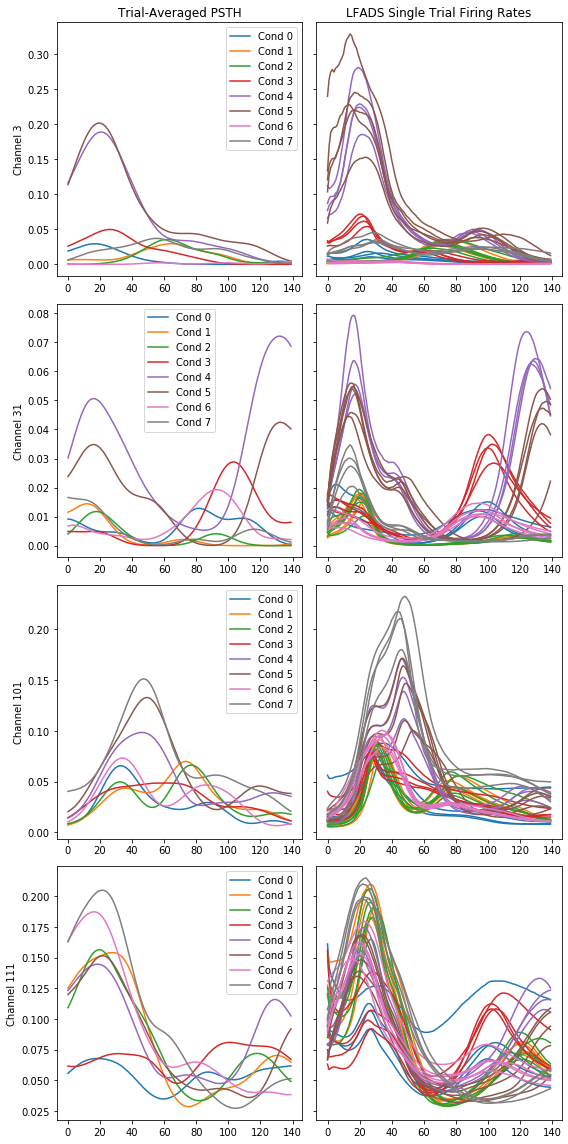

In [23]:
import matplotlib.pyplot as plt

# specify the channels and conditions you want to plot
ch_list = [3, 31, 101, 111]  # channels to plot
cond_list = [0, 1, 2, 3, 4, 5, 6, 7]  # conditions to plot

n_ch_plt = len(ch_list)  # number of channels to plot
n_cond_plt = len(cond_list)  # number of conditions to plot
fig, axes = plt.subplots(ncols=2,
                         nrows=n_ch_plt,
                         figsize=(8, n_ch_plt * 4),
                         sharey='row')
for i_ch, ch in enumerate(ch_list):  # for each channel
    for i_cond, cond in enumerate(cond_list):  # for each condition
        # plot the PSTH for this condition
        axes[i_ch, 0].plot(true_list[cond][:, ch],
                           label=f'Cond {cond}',
                           color=f'C{i_cond}')
        axes[i_ch, 0].legend()

        # plt the LFADS-inferred firing rates for this condition
        cond_rates = np.array(
            [eval_rates[itrial] for itrial in eval_cond_idx[cond]])
        axes[i_ch, 1].plot(cond_rates[:, :, ch].T, color=f'C{i_cond}')
    axes[i_ch, 0].set_ylabel(f'Channel {ch}')
axes[0, 0].set_title('Trial-Averaged PSTH')
axes[0, 1].set_title('LFADS Single Trial Firing Rates')
plt.tight_layout()